# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

<b>Технологический процесс</b>

<ul>
<li>Rougher feed — исходное сырье</li>
<li>Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant:
<ul><li>Xanthate **— ксантогенат (промотер, или активатор флотации);</li>
<li>Sulphate — сульфат (на данном производстве сульфид натрия);</li>
<li>Depressant — депрессант (силикат натрия).</li></ul>
    </ul>
<ul>
<li>Rougher process (англ. «грубый процесс») — флотация</li>
<li>Rougher tails — отвальные хвосты</li>
<li>Float banks — флотационная установка</li>
<li>Cleaner process — очистка</li>
<li>Rougher Au — черновой концентрат золота</li>
<li>Final Au — финальный концентрат золота</li>
</ul>

<b>Параметры этапов</b>

<ul>
<li>air amount — объём воздуха</li>
<li>fluid levels — уровень жидкости</li>
<li>feed size — размер гранул сырья</li>
<li>feed rate — скорость подачи</li></ul>


<b>Наименование признаков</b>

<p>Наименование признаков должно быть такое:</p>
<p>[этап].[тип_параметра].[название_параметра]</p>
<p>Пример: rougher.input.feed_ag</p>
<p>Возможные значения для блока [этап]:</p>
<ul>
<li>rougher — флотация</li>
<li>primary_cleaner — первичная очистка</li>
<li>secondary_cleaner — вторичная очистка</li>
<li>final — финальные характеристики</li></ul>
Возможные значения для блока [тип_параметра]:
    <ul>
<li>input — параметры сырья</li>
<li>output — параметры продукта</li>
<li>state — параметры, характеризующие текущее состояние этапа</li>
<li>calculation — расчётные характеристики</li>
</ul>

## Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble  import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

### Анализ данных

In [ ]:
df_train=pd.read_csv('/datasets/gold_recovery_train_new.csv',parse_dates=['date']) #обучающая выборка
df_test=pd.read_csv('/datasets/gold_recovery_test_new.csv',parse_dates=['date']) #тестовая выборка
df_full=pd.read_csv('/datasets/gold_recovery_full_new.csv',parse_dates=['date']) #исходные данные

<b>Исходные данные</b>

<i>Общая информация о признаках (количество строк, пропусков и типов данных)</i>

In [ ]:
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final.

<b>В первом столбце для удобства пользования данные сразу привели к типу datetime</b>

<i>Фрагмент таблицы исходных данных</i>

In [ ]:
print(df_full.head(5))
print(df_full.shape)

                 date  final.output.concentrate_ag  \
0 2016-01-15 00:00:00                     6.055403   
1 2016-01-15 01:00:00                     6.029369   
2 2016-01-15 02:00:00                     6.055926   
3 2016-01-15 03:00:00                     6.047977   
4 2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445

<b>Посмотрим пропуски в исходных данных в процентном соотношении</b>

In [ ]:
pd.DataFrame(df_full.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
secondary_cleaner.output.tail_sol,8.992232
rougher.input.floatbank11_xanthate,2.330367
rougher.state.floatbank10_e_air,2.242914
primary_cleaner.output.concentrate_sol,1.903390
secondary_cleaner.state.floatbank2_a_air,1.131745
final.output.concentrate_sol,1.085447
rougher.input.feed_size,0.745923
primary_cleaner.output.concentrate_pb,0.596739
primary_cleaner.input.xanthate,0.535007
final.output.tail_pb,0.519574


In [ ]:
df_full.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

In [ ]:
print('Дубликаты в исходных данных',df_full.duplicated().sum())

Дубликаты в исходных данных 0


<b>Обучающая выборка</b>

<i>Общая информация о признаках в обучающей выборке(количество строк, пропусков и типов данных)</i>

In [ ]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14049 non-null  float64       
 8   final.

<i>Фрагмент таблицы обучающей выборки</i>

In [ ]:
print(df_train.head(5))
print(df_train.shape)

                 date  final.output.concentrate_ag  \
0 2016-01-15 00:00:00                     6.055403   
1 2016-01-15 01:00:00                     6.029369   
2 2016-01-15 02:00:00                     6.055926   
3 2016-01-15 03:00:00                     6.047977   
4 2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445

<i>Пропуски в обучающей выборке в процентном соотношении</i>

In [ ]:
pd.DataFrame(df_train.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
secondary_cleaner.output.tail_sol,11.343558
rougher.state.floatbank10_e_air,3.081490
rougher.input.floatbank11_xanthate,3.024949
primary_cleaner.output.concentrate_sol,2.021344
secondary_cleaner.state.floatbank2_a_air,1.533677
final.output.concentrate_sol,1.491271
rougher.input.feed_size,1.017740
final.output.tail_pb,0.706764
rougher.input.feed_pb,0.706764
primary_cleaner.input.xanthate,0.706764


In [ ]:
df_train.isnull().sum()

date                                            0
final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 87, dtype: int64

<i>Наличие дубликатов в выборке</i>

In [ ]:
print('Дубликаты в обучающей выборке',df_train.duplicated().sum())

Дубликаты в обучающей выборке 0


<b>Тестовая выборка</b>

<i>Общая информация о признаках в тестовой выборке(количество строк, пропусков и типов данных)</i>

In [ ]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

<i>Фрагмент таблицы тестовой выборки</i>

In [ ]:
print(df_test.head(5))
print(df_test.shape)

                 date  primary_cleaner.input.sulfate  \
0 2016-09-01 00:59:59                     210.800909   
1 2016-09-01 01:59:59                     215.392455   
2 2016-09-01 02:59:59                     215.259946   
3 2016-09-01 03:59:59                     215.336236   
4 2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   

<i>Пропуски в тестовой выборке в процентном соотношении</i>

In [ ]:
pd.DataFrame(df_test.isna().mean()*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')

,0
rougher.input.floatbank11_xanthate,0.472590
rougher.input.feed_sol,0.396975
secondary_cleaner.state.floatbank3_a_air,0.170132
rougher.input.floatbank11_sulfate,0.151229
primary_cleaner.input.depressant,0.094518
rougher.input.floatbank10_sulfate,0.094518
primary_cleaner.input.sulfate,0.075614
primary_cleaner.input.xanthate,0.075614
secondary_cleaner.state.floatbank2_a_air,0.056711
rougher.input.feed_rate,0.056711


<div class="alert alert-success"> ✅
<h3> Комментарий ревьюера v1</h3>

Данные загружены, первичный осмотр и выводы корректные


### Проверим правильность подсчета эффективности обогащения

Для подсчета эффективности необходимы следующие входные параметры:
<ul>
    <li>C — доля золота в концентрате после флотации/очистки (<b>rougher.output.concentrate_au</b>)</li>
    <li>F — доля золота в сырье/концентрате до флотации/очистки (<b>rougher.input.feed_au)</b></li>
    <li>T — доля золота в отвальных хвостах после флотации/очистки <b>(rougher.output.tail_au</b>)</li></ul>

In [ ]:
recovery=df_train['rougher.output.concentrate_au']\
*(df_train['rougher.input.feed_au']-df_train['rougher.output.tail_au'])/\
(df_train['rougher.input.feed_au']*(df_train['rougher.output.concentrate_au']-df_train['rougher.output.tail_au']))*100
print(recovery)
print('Среднее абсолютное отклонение',mean_absolute_error(recovery, df_train['rougher.output.recovery']))

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
14144    89.574376
14145    87.724007
14146    88.890579
14147    89.858126
14148    89.514960
Length: 14149, dtype: float64
Среднее абсолютное отклонение 9.73512347450521e-15


Полученное низкое значение МАЕ, говорит о том, что вычисления произведены верно

### Проанализируем признаки, недоступные в тестовой выборке

In [ ]:
col_train=df_train.columns
col_test=df_test.columns
col_full=df_full.columns
failing=[]

In [ ]:
for i in range(len(col_full)):
    if col_full[i] not in col_test:
        failing.append(col_full[i])
print('Количество отсутствующих признаков', len(col_full)-len(col_test))

Количество отсутствующих признаков 34


In [ ]:
def fl(failing,s):
    r=[]
    for i in range(len(failing)):
        if s in failing[i] and failing[i] not in r:
            r.append(failing[i])
            if 'recovery' in failing[i]:
                print("*****",failing[i],"*****")
            print(failing[i])

In [ ]:
print('Параметры продукта на этапе флотации:')
fl(failing,'rougher.output')
print('Параметры продукта на этапе первичной очистки:')
fl(failing,'primary_cleaner.output')
print('Параметры продукта на этапе вторичной очистки:')
fl(failing,'secondary_cleaner.output')
print('Финальные параметры продукта:')
fl(failing, 'final.output')

Параметры продукта на этапе флотации:
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.concentrate_au
***** rougher.output.recovery *****
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
rougher.output.tail_au
Параметры продукта на этапе первичной очистки:
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
primary_cleaner.output.tail_au
Параметры продукта на этапе вторичной очистки:
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.output.tail_sol
secondary_cleaner.output.tail_au
Финальные параметры продукта:
final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol
final.output.concentrate_au
***** final.output.recovery *****
final.

<b>Предварительный вывод #1: </b>
<ul>
    <li>В данных отсутствуют данные по многим признакам</li>
    <li>В некоторых признаках есть пропуски (final.output.concentrate_sol)</li>
    <li>Дубликаты отсутствуют</li>
    <li>Тип данных не менялся, за исключением первого столбца (изменен на datetime)</li>
    <li>В тестовой выборке отсутствуют 34 признака, а именно параметры продукта на всех этапах (флотация, первичная очистка, вторичная очистка, финал), а также расчетные характеристики на этапе флотации. </li>
     <li>Стоит также обратить внимание на отсутствие признаков <b>rougher.output.recovery</b> и <b>final.output.recovery</b>, вероятно это целевые признаки.</p> </li>
     <li>Расчет эффективности обогащения произведен верно.</li>

### Проведем предобработку данных

Избавимся от пропусков

In [ ]:
df_train = df_train.ffill(axis=0)
df_test = df_test.ffill(axis=0)
df_full = df_full.ffill(axis=0)

In [ ]:
df_full.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [ ]:
df_train.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [ ]:
df_test.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

In [ ]:
print('Дубликаты в тестовой выборке',df_test.duplicated().sum())

Дубликаты в тестовой выборке 0


In [ ]:
drop=df_full[(df_full['rougher.output.concentrate_au']==0)\
            |(df_full['primary_cleaner.output.concentrate_au']==0)\
            |(df_full['final.output.concentrate_au']==0)]['date']

<b>Добавим целевые признаки из полного датасета в тестовую выборку:</b>

In [ ]:
df_test = df_test.merge(df_full.loc[:, ['date','rougher.output.recovery','final.output.recovery']], on='date')

## Анализ данных

### Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

In [ ]:
def plot_concentrate(a,b,c,d,s):
    fig = plt.figure(figsize=(20, 7))
    plt.hist(a, bins=200, alpha = 0.45, label='исходное сырье')
    plt.hist(b, bins=200, alpha = 0.45, label='после флотации')
    plt.hist(c, bins=200, alpha = 0.45, label='после первичной обработки')
    plt.hist(d, bins=200, alpha = 0.45, label='финальная обработка')
    plt.legend(loc='upper left')
    plt.title(s)
    plt.xlabel('концентрация металла')
    plt.ylabel('Количество наблюдений')
    plt.show()

In [ ]:
def plot_feed(a,b,c,d,s):
    rougher.input.feed_au
    fig = plt.figure(figsize=(20, 7))
    plt.hist(a, bins=200, alpha = 0.45, label='на этапе флотации')
    plt.hist(d, bins=200, alpha = 0.45, label='на финальном этапе')
    plt.hist(c, bins=200, alpha = 0.45, label='после первичной обработки')
    plt.hist(b, bins=200, alpha = 0.45, label='после вторичной обработки')
    plt.legend(loc='upper left')
    plt.title(s)
    plt.xlabel('концентрация металла')
    plt.ylabel('Количество наблюдений')
    plt.show()

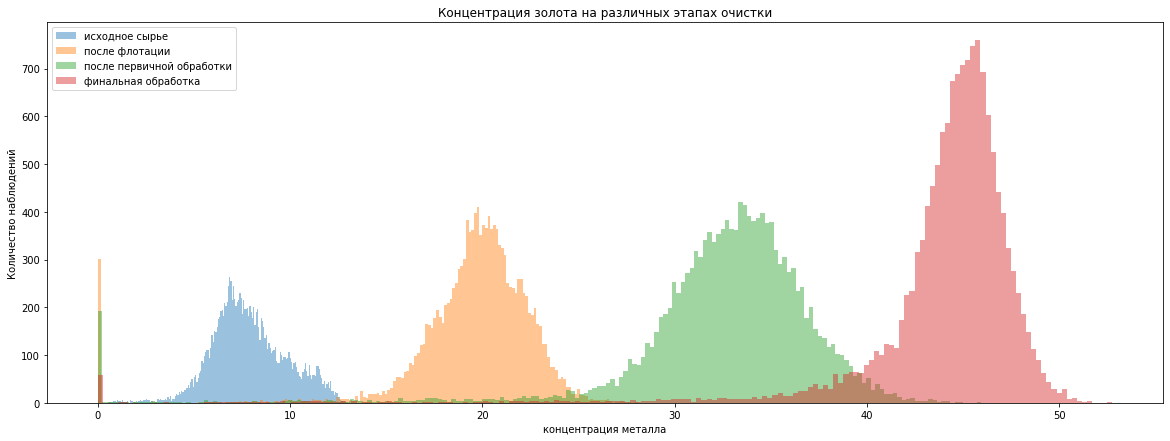

In [ ]:
a= df_train['rougher.input.feed_au']
b = df_train['rougher.output.concentrate_au']
c = df_train['primary_cleaner.output.concentrate_au']
d = df_train['final.output.concentrate_au']
s='Концентрация золота на различных этапах очистки'
plot_concentrate(a,b,c,d,s)

<div class="alert alert-info">Добавлен коментарий</div>

Концентрация золота после каждого этапа обработки увеличивается. Наибольшие значения наблюдаются после вторичной обработки

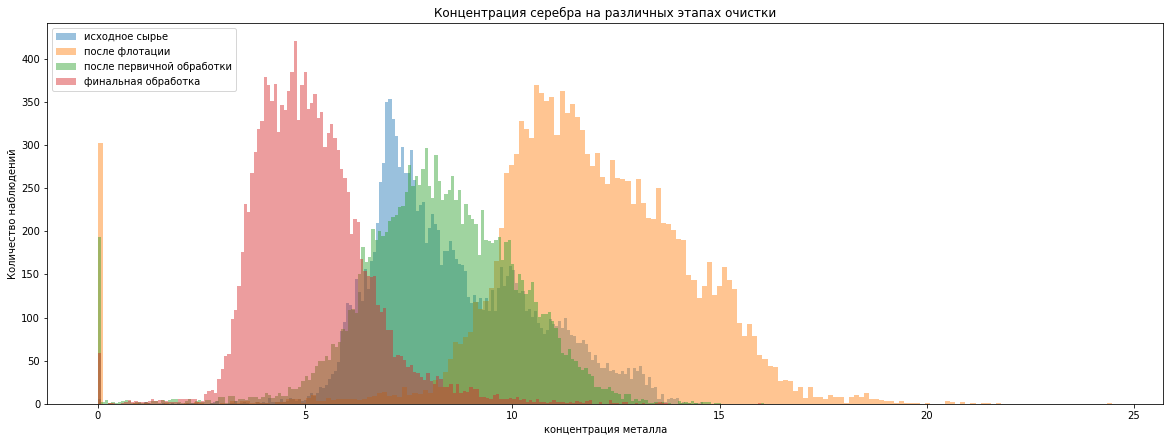

In [ ]:
a = df_train['rougher.input.feed_ag']
b= df_train['rougher.output.concentrate_ag']
c = df_train['primary_cleaner.output.concentrate_ag']
d = df_train['final.output.concentrate_ag']
s='Концентрация серебра на различных этапах очистки'
plot_concentrate(a,b,c,d,s)

<div class="alert alert-info">Добавлен коментарий</div>

Концентрация серебра на этапе флотации и первичной обработки мало отличаются. Однако значения на финальном этапе обработки значительно снижаются.

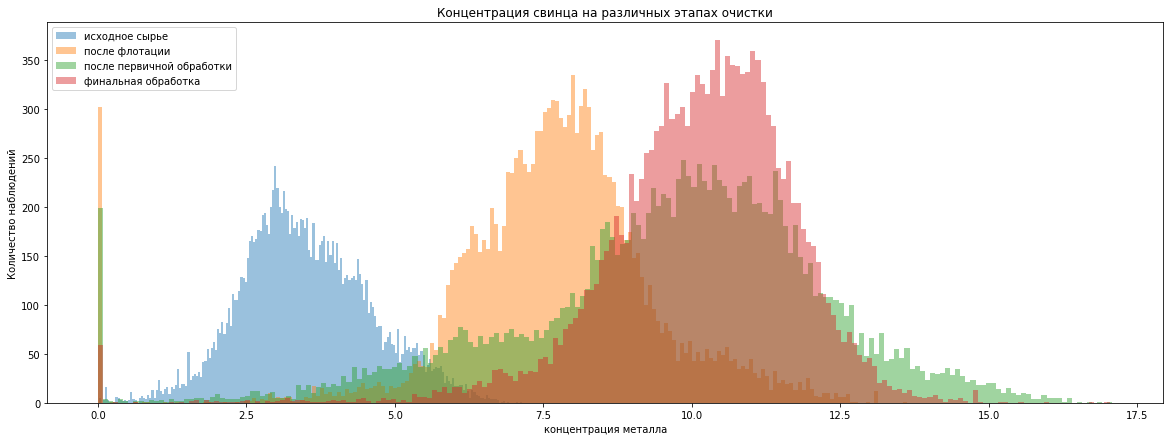

In [ ]:
a = df_train['rougher.input.feed_pb']
b= df_train['rougher.output.concentrate_pb']
c = df_train['primary_cleaner.output.concentrate_pb']
d = df_train['final.output.concentrate_pb']
s='Концентрация свинца на различных этапах очистки'
plot_concentrate(a,b,c,d,s)

<div class="alert alert-info">Добавлен коментарий</div>

Концентрация свинца растет, однако финальный уровень не превышает уровня первичной обработки.

<div class="alert alert-danger"> ❌
<h3> Комментарий ревьюера v1</h3>

Что из этого следует? Я вижу, что есть выводы в конце раздела. Но нужны мини-выводы/мысли после каждого этапа, иначе сложно понять, что к чему относится

 ### Сравним распределение размеров гранул сырья на обучающей и тестовой выборках

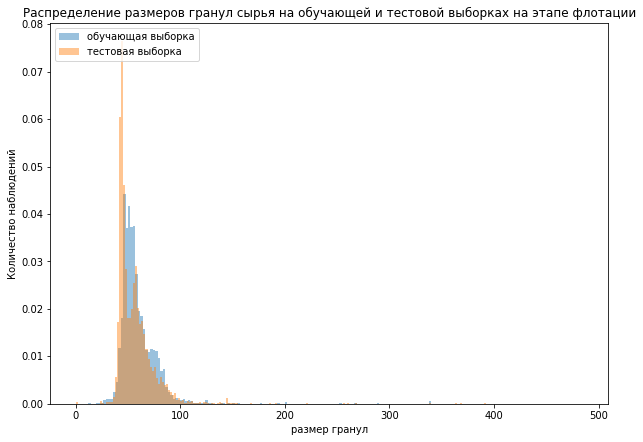

In [ ]:
a = df_train['rougher.input.feed_size']
b = df_test['rougher.input.feed_size']

fig = plt.figure(figsize=(10, 7))
plt.hist(a, bins=200, alpha = 0.45, label='обучающая выборка',density=True)
plt.hist(b, bins=200, alpha = 0.45, label='тестовая выборка',density=True)
plt.legend(loc='upper left')
plt.title("Распределение размеров гранул сырья на обучающей и тестовой выборках на этапе флотации")
plt.xlabel('размер гранул')
plt.ylabel('Количество наблюдений')
plt.show()

<div class="alert alert-info">Добавлен коментарий</div>

Размеры гранул сырья находятся в диапазоне (0,100), причем характер распределения почти одинаковый

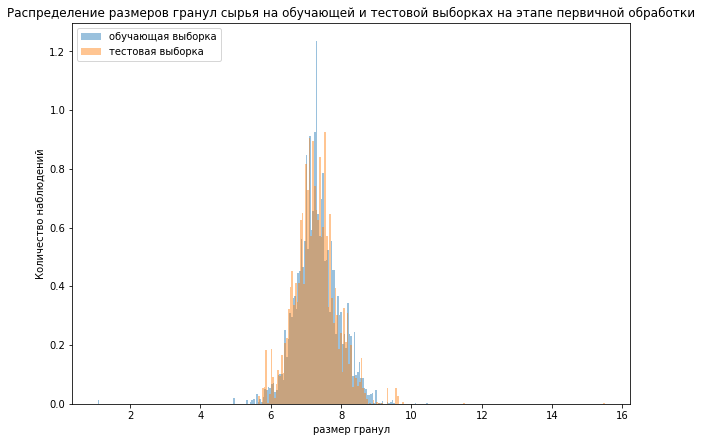

In [ ]:
a = df_train['primary_cleaner.input.feed_size']
b = df_test['primary_cleaner.input.feed_size']
x = np.arange(0, 100, 0.1)

fig = plt.figure(figsize=(10, 7))
plt.hist(a, bins=200, alpha = 0.45, label='обучающая выборка',density=True)
plt.hist(b, bins=200, alpha = 0.45, label='тестовая выборка',density=True)
plt.legend(loc='upper left')
plt.title("Распределение размеров гранул сырья на обучающей и тестовой выборках на этапе первичной обработки")
plt.xlabel('размер гранул')
plt.ylabel('Количество наблюдений')
plt.show()

<div class="alert alert-info">Добавлен коментарий</div>

Размер гранул на этапе первичной обработки находится в основном диапазоне (5,10). Характер распределения в выборках практически совпадает

### Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.

In [ ]:
def sum_concentrate(a,b,c,d):
    sum=0
    sum = a+b+c+d
    return sum

In [ ]:
a=df_train['rougher.input.feed_au']
b=df_train['rougher.input.feed_ag']
c=df_train['rougher.input.feed_pb']
d=df_train['rougher.input.feed_sol']
df_train['sum_rougher_input']=sum_concentrate(a,b,c,d)

In [ ]:
a=df_train['rougher.output.concentrate_ag']
b=df_train['rougher.output.concentrate_pb']
c=df_train['rougher.output.concentrate_au']
d=df_train['rougher.output.concentrate_sol']
df_train['sum_rougher_output']=sum_concentrate(a,b,c,d)

In [ ]:
a=df_train['final.output.concentrate_ag']
b=df_train['final.output.concentrate_pb']
c=df_train['final.output.concentrate_au']
d=df_train['final.output.concentrate_sol']
df_train['sum_final_output']=sum_concentrate(a,b,c,d)

Удалим выбросы в районе нуля, которые мы наблюдали на отдельных графиках концентрации веществ

In [ ]:
df_train=df_train[(df_train['rougher.output.concentrate_au']>0) \
    & (df_train['rougher.output.concentrate_ag']>0)\
    & (df_train['rougher.output.concentrate_pb']>0)\
    &(df_train['rougher.output.concentrate_sol']>0)]
df_train=df_train[(df_train['final.output.concentrate_au']>0)\
    & (df_train['final.output.concentrate_ag']>0)\
    & (df_train['final.output.concentrate_pb']>0)\
    & (df_train['final.output.concentrate_sol']>0)]

In [ ]:
df_full=df_full[(df_full['rougher.output.concentrate_au']>0) \
    & (df_full['rougher.output.concentrate_ag']>0)\
    & (df_full['rougher.output.concentrate_pb']>0)\
    &(df_full['rougher.output.concentrate_sol']>0)]
df_full=df_full[(df_full['final.output.concentrate_au']>0)\
    & (df_full['final.output.concentrate_ag']>0)\
    & (df_full['final.output.concentrate_pb']>0)\
    & (df_full['final.output.concentrate_sol']>0)]

Построим график суммарной концентрации веществ на различных стадиях

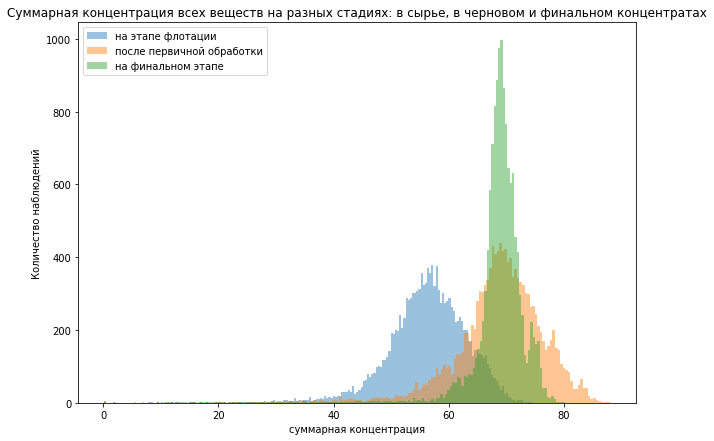

In [ ]:
fig = plt.figure(figsize=(10, 7))
plt.hist(df_train['sum_rougher_input'], bins=200, alpha = 0.45, label='на этапе флотации')
plt.hist(df_train['sum_rougher_output'], bins=200, alpha = 0.45, label='после первичной обработки')
plt.hist(df_train['sum_final_output'], bins=200, alpha = 0.45, label='на финальном этапе')

plt.legend(loc='upper left')
plt.title('Cуммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах')
plt.xlabel('суммарная концентрация')
plt.ylabel('Количество наблюдений')
plt.show()

<div class="alert alert-info">Добавлен коментарий</div>

На этапе первичной обработки и финальном этапе суммарная концентрация веществ увеличивается и находится в диапазоне (55,80), однако длина диапазона в финале заметно сокращается

In [ ]:
failing.remove('rougher.output.recovery')
failing.remove('final.output.recovery')
df_train.drop(failing, axis=1, inplace=True)
df_train.drop(['sum_rougher_input','sum_rougher_output','sum_final_output','date'], axis=1, inplace=True)

In [ ]:
df_test.drop(['date'], axis=1, inplace=True)

<b>Предварительный вывод #2: </b>
<ul>
    <li>Пропуски были удалены</li>
    <li>Были добавлены целевые признаки из полного датасета в тестовую выборку</li>
    <li>Был удален столбец с датой из всех выборок</li>
    <li>В результате оценки процентного содержания металлов после этапов обработки, можно заключить,
    что процентное содержание золота от этапа к этапу увеличивается; содержание серебра - постепенно уменьшается, а процент свинца растет, но не превышает уровня после флотации;</li>
    <li>Характер распределения гранул сырья в обучающей и тренировочной выборках остается неизменным, отличие в диапазонах значений;</li>
    <li>Диапазон распеределения суммарной концентрации веществ к финальному этапу уменьшается;</li>
    <li>На графиках видны выбросы в районе 0 (считаем целесообразным их удалить для корректности дальнейших исследований)</li>

## Построим модель прогнозирования

### Рассчитаем симметричную среднюю абсолютную процентную ошибку (SMAPE)

In [ ]:
def smape(target, predict):
    return (1/len(target))*np.sum((np.abs(target - predict))/( (np.abs(target)+np.abs(predict))/2))*100

Напишем функцию нахождения итогового sMAPE

In [ ]:
def fin_smape(rougher,final):
     return 0.25*rougher+0.75*final

### Обучим разные модели и оценим их качество кросс-валидацией

In [ ]:
features_train = df_train.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train_rougher = df_train['rougher.output.recovery'] # выделим целевые признаки
target_train_final = df_train['final.output.recovery']

In [ ]:
custom_score = make_scorer(smape,greater_is_better=False)

In [ ]:
X_train = features_train
y_train1 = target_train_rougher
y_train2 = target_train_final

<b>Модель DecisionTreeRegressor</b>

<i>Подберем опртимальные параметры для модели DecisionTreeRegressor:</i>

In [ ]:
%%time
clf = DecisionTreeRegressor()
parametrs = {
           'max_depth': range (2,13, 2)}
grid = GridSearchCV(clf, parametrs, scoring=custom_score, cv=5)
grid.fit(X_train, y_train1)
grid.best_params_

CPU times: user 10.7 s, sys: 7.04 ms, total: 10.7 s
Wall time: 10.7 s


{'max_depth': 4}

In [ ]:
%%time
clf = DecisionTreeRegressor()
parametrs = {
           'max_depth': range (2,13, 2)}
grid = GridSearchCV(clf, parametrs, scoring=custom_score, cv=5)
grid.fit(X_train, y_train2)
grid.best_params_

CPU times: user 10.5 s, sys: 3.67 ms, total: 10.5 s
Wall time: 10.6 s


{'max_depth': 2}

In [ ]:
model=DecisionTreeRegressor(random_state=12345,max_depth=4)
scores=cross_val_score(model,X_train, y_train1, scoring=custom_score,cv=5)
final_smape_rougher = scores.mean()
model=DecisionTreeRegressor(random_state=12345,max_depth=2)
scores=cross_val_score(model,X_train, y_train2, scoring=custom_score,cv=5)
final_smape_final = scores.mean()
result_smape_DTR=abs(fin_smape(final_smape_rougher,final_smape_final))
print(result_smape_DTR)

8.943087933998507


<b>Модель RandomForestRegressor</b>

<i>Подберем оптимальные параметры для модели RandomForestRegressor:</i>

In [ ]:
%%time
rfr = RandomForestRegressor()
parametrs = {'n_estimators': range(5,15),
             'max_depth': range (2,13, 2)}
grid = GridSearchCV(rfr, parametrs, scoring=custom_score)
grid.fit(X_train, y_train1)
grid.best_params_

CPU times: user 11min 18s, sys: 1.15 s, total: 11min 19s
Wall time: 11min 29s


{'max_depth': 4, 'n_estimators': 13}

In [ ]:
%%time
rfr = RandomForestRegressor()
parametrs = {'n_estimators': range(4,15,2),
             'max_depth': range (2,13, 2)}
grid = GridSearchCV(rfr, parametrs, scoring=custom_score)
grid.fit(X_train, y_train2)
grid.best_params_

CPU times: user 5min 26s, sys: 541 ms, total: 5min 27s
Wall time: 5min 27s


{'max_depth': 4, 'n_estimators': 6}

In [ ]:
model=RandomForestRegressor(random_state=12345,n_estimators=12, max_depth=4)
scores=cross_val_score(model,X_train, y_train1, scoring=custom_score,cv=5)
final_smape_rougher = scores.mean()
model=RandomForestRegressor(random_state=12345,n_estimators=10, max_depth=4)
scores=cross_val_score(model,X_train, y_train2, scoring=custom_score,cv=5)
final_smape_final = scores.mean()
result_smape_RFR=abs(fin_smape(final_smape_rougher,final_smape_final))
print(result_smape_RFR)

8.542982342307454


<b>Модель LinearRegression</b>

In [ ]:
model = LinearRegression()
smape_rougher = cross_val_score(model,X_train,y_train1,scoring=custom_score,cv=5)
final_smape_rougher = smape_rougher.mean()
smape_final = cross_val_score(model,X_train,y_train2,scoring=custom_score,cv=5)
final_smape_final=smape_final.mean()
result_smape_LR=abs(fin_smape(final_smape_rougher,final_smape_final))
print(result_smape_LR)

10.059261443482796


### Проверим модель RandomForestRegressor на тестовой выборке

In [ ]:
features_test = df_test.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test_rougher = df_test['rougher.output.recovery'] # выделим целевые признаки
target_test_final = df_test['final.output.recovery']

In [ ]:
model_RFR_rougher=RandomForestRegressor(random_state=12345,n_estimators=12, max_depth=4)
model_RFR_rougher.fit(features_test, target_test_rougher)
predicted_rougher = model_RFR_rougher.predict(features_test)

In [ ]:
model_RFR_final=RandomForestRegressor(random_state=12345,n_estimators=12, max_depth=4)
model_RFR_final.fit(features_test, target_test_final)
predicted_final = model_RFR_final.predict(features_test)

In [ ]:
smape_rougher = smape(target_test_rougher, predicted_rougher)
smape_final = smape(target_test_final, predicted_final)
final_smape_test =fin_smape(smape_rougher, smape_final)
print(final_smape_test)

7.932438132393052


In [ ]:
print('Сравнительная таблица. Cимметричная средняя абсолютная процентная ошибка sMAPE')
final_table=[['DecisionTreeRegressor','RandomForestRegressor','LinearRegression'],
             [round(result_smape_DTR,2),round(result_smape_RFR,2),round(result_smape_LR,2)] ]
for row in final_table:
    for col in row:
        print(f'{col:<22}', end='|  ')
    print()

Сравнительная таблица. Cимметричная средняя абсолютная процентная ошибка sMAPE
DecisionTreeRegressor |  RandomForestRegressor |  LinearRegression      |  
8.94                  |  8.54                  |  10.06                 |  


### Проверим модель на адекватность

In [ ]:
dummy_rougher = DummyRegressor(strategy="median")
dummy_rougher.fit(X_train,target_train_rougher)
rougher_pred = dummy_rougher.predict(target_test_rougher)
smape_dummy_rougher = smape(target_test_rougher, rougher_pred)

dummy_final = DummyRegressor(strategy="median")
dummy_final.fit(X_train,target_train_final)
final_pred = dummy_final.predict(target_test_final)
smape_dummy_final = smape(target_test_final, final_pred)
final_smape_test =fin_smape(smape_dummy_rougher, smape_dummy_final)
print(final_smape_test)

9.438536537344847


<b>Вывод #3: </b>
<ul>
    <li>Рассмотрены три модели:Модель DecisionTreeRegressor, RandomForestRegressor и LinearRegression. Лучший результат показала модель - RandomForestRegressor. sMAPE этой модели, оказался наименьшим</li>
    <li>Выбранная модель была проверена на тестовой выборке и показала  sMAPE = 7,93;</li>
    <li>Модель RandomForestRegressor была проверена на адекватность DummyRegressor, показатель sMAPE оказался выше, чем на тествовой выборке, что говорит о неплохом результате. </li>